# Photometric Analysis of Stellar Clusters: Pipeline & Characterization

## Abstract
This notebook implements a robust photometric reduction pipeline designed to characterize open clusters using multi-band imaging ($g, r, i$). To mitigate field contamination and instrumental systematics, we employ a spatial filtering technique combined with a strict multi-band cross-match before performing the photometric calibration.

## Methodology
1.  **Independent Astrometry & Photometry:** Each band is processed independently to account for potential field rotation or pixel shifts.
2.  **Member Selection:** Candidates are selected based on their radial distance from the cluster center ($r < R_{lim}$) and their detection in all three passbands ($g \cap r \cap i$).
3.  **Photometric Calibration:** Zero-points are determined using the **Fixed Slope Method** (Slope = 1.0) relative to the Pan-STARRS reference catalog, ensuring physical consistency.
4.  **Isochrone Fitting:** Physical parameters (Age, Distance, Extinction) are derived by fitting PARSEC evolutionary tracks to the cleaned Color-Magnitude Diagram.

In [712]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from astroquery.vizier import Vizier
from scipy.stats import linregress
from astropy.table import Table
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')

## 1. Configuration and Optical Parameters

Definition of input data paths, Point Spread Function (PSF) properties, and selection criteria.

In [713]:
# Input FITS files
stack_g_path = 'stacks/lyon/stack_g.fits'
stack_r_path = 'stacks/lyon/stack_r.fits'
stack_i_path = 'stacks/lyon/stack_i.fits'

# Photometry settings
fwhm = 5.0
aperture_radius = 2 * fwhm / 2.355
sigma_thresh = 5.0

# Catalog matching settings
match_radius_arcsec = 5
use_panstarrs = True

# --- SPATIAL FILTERING PARAMETER ---
# Radius limit to segregate cluster members from field stars.
CLUSTER_RADIUS_DEG = 0.20

# Isochrone Fitting Initial Guesses
DISTANCE_MODULUS = 11.3
E_BV = 0.65

# CMD Axes Definition
PLOT_COLOR_1 = 'g'
PLOT_COLOR_2 = 'r'
PLOT_MAG = 'g'

## 2. Astrometric Solution and Pre-processing

We utilize `solve-field` (*Astrometry.net*) to compute the WCS solution for each band. This step is critical to align the frames and convert pixel coordinates $(x,y)$ to celestial coordinates $(\alpha, \delta)$.

In [714]:
def solve_astrometry(input_fits):
    """Solve astrometry using local solver."""
    output_fits = input_fits.replace('.fits', '_wcs.fits')
    if not os.path.exists(output_fits):
        print(f'Solving astrometry for {input_fits}...')
        cmd = ['solve-field', input_fits, '--overwrite', '--no-plots', '--new-fits', output_fits]
        subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return output_fits

stack_g_wcs = solve_astrometry(stack_g_path)
stack_r_wcs = solve_astrometry(stack_r_path)
stack_i_wcs = solve_astrometry(stack_i_path)

# Load data arrays
g_hdul = fits.open(stack_g_wcs)
r_hdul = fits.open(stack_r_wcs)
i_hdul = fits.open(stack_i_wcs)

g_data = g_hdul[0].data.astype(float)
r_data = r_hdul[0].data.astype(float)
i_data = i_hdul[0].data.astype(float)

# Background Subtraction (Sigma-clipped Median)
for data in [g_data, r_data, i_data]:
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    data -= median

wcs = WCS(g_hdul[0].header)
print('Data loaded and background subtracted successfully.')

Data loaded and background subtracted successfully.


## 3. Source Detection and Instrumental Photometry

Sources are detected independently in each filter using a Gaussian PSF kernel (`DAOStarFinder`). Flux is measured via aperture photometry.

In [715]:
def detect_sources(data, fwhm, sigma):
    """Detect point sources above sigma threshold."""
    mean, median, std = sigma_clipped_stats(data, sigma=2.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma * std)
    return daofind(data - median)

sources_g = detect_sources(g_data, fwhm, sigma_thresh)
sources_r = detect_sources(r_data, fwhm, sigma_thresh)
sources_i = detect_sources(i_data, fwhm, sigma_thresh)
print(f"Detections (Raw): g={len(sources_g)}, r={len(sources_r)}, i={len(sources_i)}")

def do_photometry(data, sources, radius):
    """Compute instrumental magnitudes."""
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    ap = CircularAperture(positions, r=radius)
    phot = aperture_photometry(data, ap)
    # m_inst = -2.5 * log10(Flux)
    phot['mag_inst'] = -2.5 * np.log10(phot['aperture_sum'])
    return phot

phot_g = do_photometry(g_data, sources_g, aperture_radius)
phot_r = do_photometry(r_data, sources_r, aperture_radius)
phot_i = do_photometry(i_data, sources_i, aperture_radius)

Detections (Raw): g=708, r=927, i=661


## 4. WCS Transformation

Converting $(x,y)$ pixel coordinates to Equatorial $(RA, Dec)$ coordinates.

In [716]:
def add_sky_coords(phot_table, wcs_obj):
    pix = np.transpose((phot_table['xcenter'], phot_table['ycenter']))
    world = wcs_obj.all_pix2world(pix, 1)
    return SkyCoord(ra=world[:,0]*u.deg, dec=world[:,1]*u.deg)

coords_g = add_sky_coords(phot_g, wcs)
coords_r = add_sky_coords(phot_r, wcs)
coords_i = add_sky_coords(phot_i, wcs)
print('WCS coordinates computed.')

WCS coordinates computed.


## 4.1 Data Reduction: Spatial Filtering & Cross-Match

To ensure the purity of the cluster sample, we apply the following filters:
1.  **Spatial Cut:** Selecting stars within `CLUSTER_RADIUS_DEG` from the cluster center.
2.  **Intersection:** Keeping only sources detected in all three bands ($g \cap r \cap i$).

Estimated Center: RA=351.2106, Dec=61.6002
Applying Spatial Cut: Radius < 0.2 deg
--- Post-Spatial Filter Counts ---
  g: 708 | r: 927 | i: 660


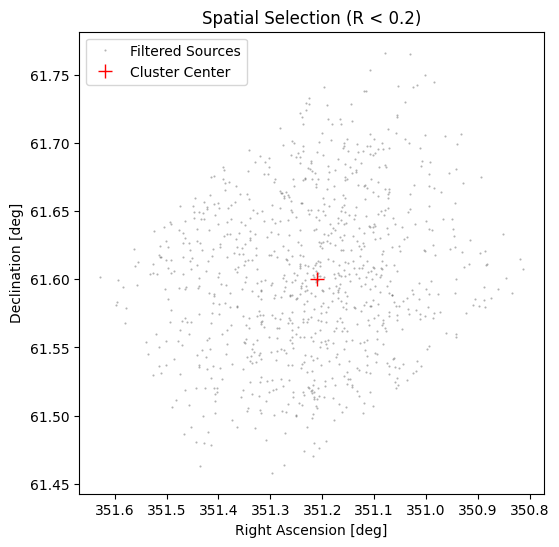

In [717]:
# 1. Define Cluster Center (Median of g-band sources)
ra_cen = np.median(coords_g.ra.deg)
dec_cen = np.median(coords_g.dec.deg)
center = SkyCoord(ra_cen, dec_cen, unit='deg')

print(f"Estimated Center: RA={ra_cen:.4f}, Dec={dec_cen:.4f}")
print(f"Applying Spatial Cut: Radius < {CLUSTER_RADIUS_DEG} deg")

# Spatial Filter Function
def filter_by_radius(phot_table, coords, center, radius_deg):
    sep = coords.separation(center)
    mask = sep < radius_deg * u.deg
    return phot_table[mask], coords[mask]

# Apply filter
phot_g, coords_g = filter_by_radius(phot_g, coords_g, center, CLUSTER_RADIUS_DEG)
phot_r, coords_r = filter_by_radius(phot_r, coords_r, center, CLUSTER_RADIUS_DEG)
phot_i, coords_i = filter_by_radius(phot_i, coords_i, center, CLUSTER_RADIUS_DEG)

print(f"--- Post-Spatial Filter Counts ---")
print(f"  g: {len(phot_g)} | r: {len(phot_r)} | i: {len(phot_i)}")

# --- VISUALIZATION: Field vs Selection ---
plt.figure(figsize=(6, 6))
# Note: We plot the filtered r and i sources just to visualize density
plt.plot(coords_r.ra.deg, coords_r.dec.deg, 'k.', ms=1, alpha=0.3, label='Filtered Sources')
plt.plot(ra_cen, dec_cen, 'r+', ms=10, label='Cluster Center')
plt.xlabel('Right Ascension [deg]')
plt.ylabel('Declination [deg]')
plt.title(f'Spatial Selection (R < {CLUSTER_RADIUS_DEG})')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

## 5. Reference Catalog Retrieval

Querying Pan-STARRS DR1 via VizieR for the selected region.

In [718]:
Vizier.ROW_LIMIT = 50000

if use_panstarrs:
    # Retrieve standard stars in the area
    filters_query = {"gmag": "<12", "rmag": "<12", "imag": "<12"}
    v = Vizier(columns=['objID','RAJ2000','DEJ2000','gmag','rmag', 'imag'], column_filters=filters_query)
    res = v.query_region(center, radius=CLUSTER_RADIUS_DEG*u.deg, catalog='II/349/ps1')
    catalog = res[0]
    catalog.rename_columns(['RAJ2000','DEJ2000'], ['ra','dec'])
    # Data cleaning
    for col in ['gmag','rmag', 'imag']:
        catalog = catalog[catalog[col] != '']
        catalog[col] = catalog[col].astype(float)
    print('Reference catalog downloaded.')

ref_coords = SkyCoord(catalog['ra'], catalog['dec'], unit='deg')

Reference catalog downloaded.


## 6. Independent Photometric Calibration

We determine the Zero-Point (ZP) for each filter. Given the linear nature of CCD detectors, we enforce a **Fixed Slope = 1.0**. The ZP is calculated as the median offset:
$$ ZP = \text{median}(m_{cat} - m_{inst}) $$

Filter g: ZP=26.126 +/- 0.221, Slope (Fixed)=1.0, N=22
Filter r: ZP=25.529 +/- 0.431, Slope (Fixed)=1.0, N=23
Filter i: ZP=24.173 +/- 0.781, Slope (Fixed)=1.0, N=24


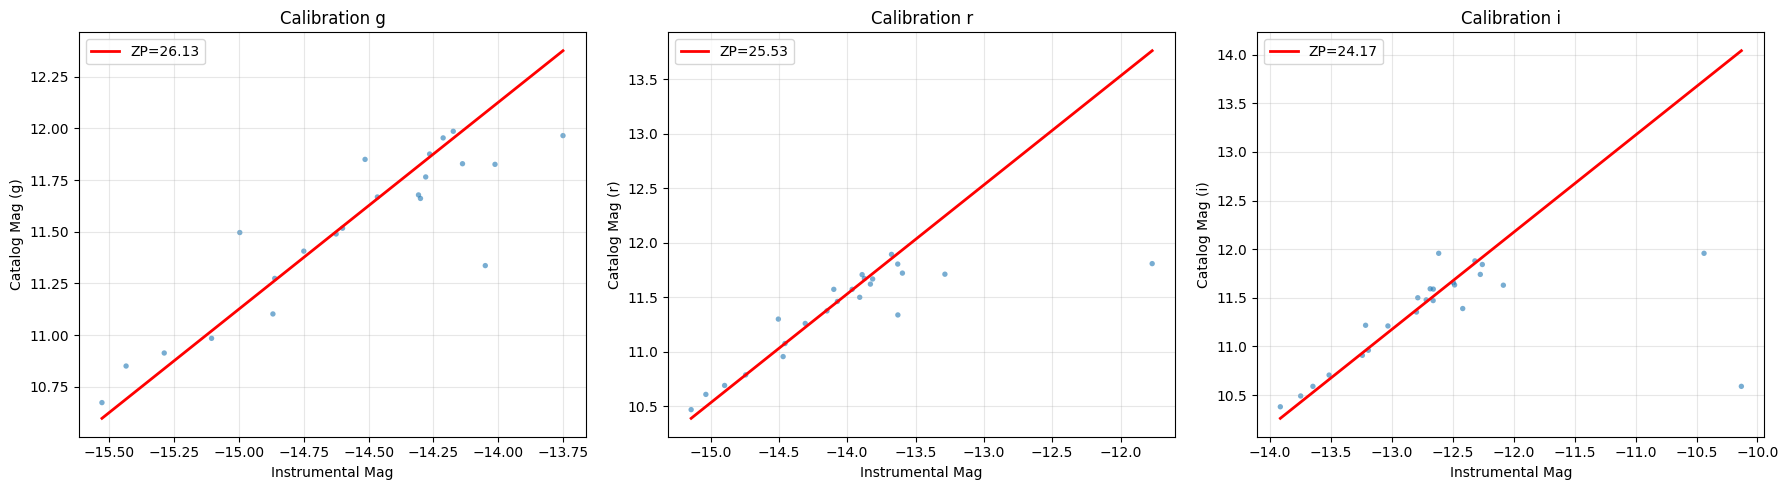

In [719]:
phot_list_map = {'g': phot_g, 'r': phot_r, 'i': phot_i}
coords_list_map = {'g': coords_g, 'r': coords_r, 'i': coords_i}
zp_results = {}

plt.figure(figsize=(18, 5))

for i, filt in enumerate(['g', 'r', 'i']):
    ax = plt.subplot(1, 3, i + 1)
    
    # Get data for current filter
    phot_tbl = phot_list_map[filt]
    coords_tbl = coords_list_map[filt]
    
    # Cross-match with Reference Catalog
    idx, d2d, _ = coords_tbl.match_to_catalog_sky(ref_coords)
    mask = d2d < match_radius_arcsec * u.arcsec
    
    matched_inst = phot_tbl[mask]
    matched_ref = catalog[idx[mask]]

    mag_inst = np.array(matched_inst['mag_inst'])
    mag_ref = np.array(matched_ref[f'{filt}mag'])

    # Clean Data
    valid = np.isfinite(mag_inst) & np.isfinite(mag_ref) & (mag_ref < 99)
    mag_inst, mag_ref = mag_inst[valid], mag_ref[valid]

    if len(mag_inst) < 5:
        print(f"Warning: Calibration failed for {filt} (insufficient stars)")
        zp_results[filt] = {'ZP': 0, 'slope': 1}
        continue
        
    # --- FIXED SLOPE CALIBRATION (Slope=1) ---
    # This method is robust against outliers and physically motivated for CCDs
    deltas = mag_ref - mag_inst
    ZP_fixed = np.median(deltas)
    slope_fixed = 1.0
    std_zp = np.std(deltas)
    
    zp_results[filt] = {'ZP': ZP_fixed, 'slope': slope_fixed}
    
    print(f"Filter {filt}: ZP={ZP_fixed:.3f} +/- {std_zp:.3f}, Slope (Fixed)=1.0, N={len(mag_inst)}")
    
    # Apply Calibration immediately
    phot_tbl['mag_cal'] = phot_tbl['mag_inst'] + ZP_fixed
    
    # Visualization
    ax.scatter(mag_inst, mag_ref, s=15, alpha=0.6, edgecolors='none')
    x_min, x_max = np.min(mag_inst), np.max(mag_inst)
    x_fit = np.array([x_min, x_max])
    ax.plot(x_fit, x_fit * 1.0 + ZP_fixed, 'r-', lw=2, label=f'ZP={ZP_fixed:.2f}')
    
    ax.set_title(f"Calibration {filt}")
    ax.set_xlabel('Instrumental Mag')
    ax.set_ylabel(f'Catalog Mag ({filt})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Final CMD Construction and Isochrone Fitting

We construct the final catalog by performing the intersection of the three calibrated bands ($g \cap r \cap i$) and plot the resulting Color-Magnitude Diagram.

In [720]:
# Apply Calibration (Already done in loop above, but ensuring consistency)
phot_g['mag_cal'] = phot_g['mag_inst'] * zp_results['g']['slope'] + zp_results['g']['ZP']
phot_r['mag_cal'] = phot_r['mag_inst'] * zp_results['r']['slope'] + zp_results['r']['ZP']
phot_i['mag_cal'] = phot_i['mag_inst'] * zp_results['i']['slope'] + zp_results['i']['ZP']

# --- INTERSECTION (CROSS-MATCH) ---
# 1. Match g <-> r
idx_gr, d2d_gr, _ = coords_g.match_to_catalog_sky(coords_r)
mask_gr = d2d_gr < match_radius_arcsec*u.arcsec

coords_gr = coords_g[mask_gr]
phot_g_final = phot_g[mask_gr]
phot_r_final = phot_r[idx_gr[mask_gr]]

# 2. Match (g+r) <-> i
idx_gi, d2d_gi, _ = coords_gr.match_to_catalog_sky(coords_i)
mask_gi = d2d_gi < match_radius_arcsec*u.arcsec

# Final aligned tables
final_g = phot_g_final[mask_gi]
final_r = phot_r_final[mask_gi]
final_i = phot_i[idx_gi[mask_gi]]
final_coords = coords_gr[mask_gi]

phot_data = {
    'g': final_g['mag_cal'],
    'r': final_r['mag_cal'],
    'i': final_i['mag_cal']
}

# Prepare Plot Data
mag1 = phot_data[PLOT_COLOR_1]
mag2 = phot_data[PLOT_COLOR_2]
mag_y = phot_data[PLOT_MAG]
color_x = mag1 - mag2

# Clean NaNs
valid = np.isfinite(color_x) & np.isfinite(mag_y)
color_x = color_x[valid]
mag_y = mag_y[valid]

print(f"Final stars for CMD: {len(color_x)}")

xlabel = f'({PLOT_COLOR_1} - {PLOT_COLOR_2}) [mag]'
ylabel = f'{PLOT_MAG} [mag]'
# Export Diagram Data
np.savetxt('hr_diagram_data_filtered.txt', np.column_stack((color_x, mag_y)), header=f'{xlabel} {ylabel}')

Final stars for CMD: 611


## 8. Isochrone Visualization

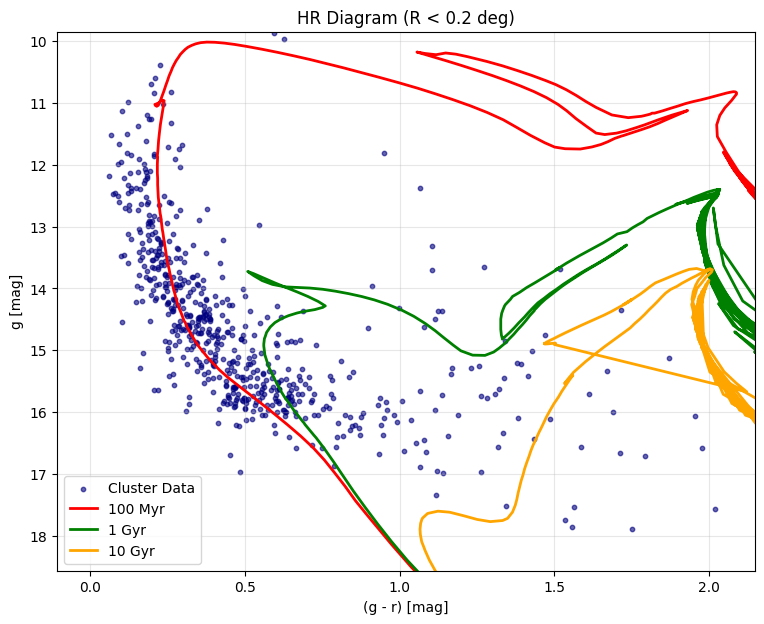

In [721]:
# Extinction Coefficients (Schlafly & Finkbeiner 2011)
EXTINCTION_COEFFS = {'g': 3.172 * E_BV, 'r': 2.271 * E_BV, 'i': 1.682 * E_BV}
ISO_COL_MAP = {'g': -4, 'r': -3, 'i': -2}

def read_isochrone(file_path, col_map, f1, f2, mag_f):
    try:
        iso = np.loadtxt(file_path, comments='#')
        return (iso[:, col_map[f1]] - iso[:, col_map[f2]]), iso[:, col_map[mag_f]]
    except: return None, None

iso_files = {
    '100 Myr': 'iso_e8.dat',
    '1 Gyr': 'iso_e9.dat',
    '10 Gyr': 'iso_e10.dat',
    '100 Myr z=0.0118': 'iso_e8_z0.0118.dat'
}

A_mag = EXTINCTION_COEFFS[PLOT_MAG]
E_color = EXTINCTION_COEFFS[PLOT_COLOR_1] - EXTINCTION_COEFFS[PLOT_COLOR_2]

plt.figure(figsize=(9, 7))
plt.scatter(color_x, mag_y, s=10, alpha=0.6, c='navy', label='Cluster Data')

colors = ['red', 'green', 'orange']
for i, (label, path) in enumerate(iso_files.items()):
    c_iso, m_iso = read_isochrone(path, ISO_COL_MAP, PLOT_COLOR_1, PLOT_COLOR_2, PLOT_MAG)
    if c_iso is not None:
        plt.plot(c_iso + E_color, m_iso + DISTANCE_MODULUS + A_mag, 
                 color=colors[i], lw=2, label=label)

plt.gca().invert_yaxis()
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(f'HR Diagram (R < {CLUSTER_RADIUS_DEG} deg)')
plt.grid(True, alpha=0.3)
plt.legend()

# Smart limits
try:
    plt.xlim(np.percentile(color_x, 1) - 0.2, np.percentile(color_x, 99) + 0.2)
    plt.ylim(np.percentile(mag_y, 99) + 1, np.percentile(mag_y, 1) - 1)
except:
    pass

plt.show()

## 9. Final Data Export

Saving the complete catalog of selected cluster members (Positions & Magnitudes) to CSV.

In [722]:
# Create Output Table
out_tab = Table()
out_tab['RA'] = final_coords.ra.deg
out_tab['DEC'] = final_coords.dec.deg
out_tab['X_pix'] = final_g['xcenter']
out_tab['Y_pix'] = final_g['ycenter']
out_tab['mag_g_inst'] = final_g['mag_inst']
out_tab['mag_r_inst'] = final_r['mag_inst']
out_tab['mag_i_inst'] = final_i['mag_inst']
out_tab['mag_g_cal'] = final_g['mag_cal']
out_tab['mag_r_cal'] = final_r['mag_cal']
out_tab['mag_i_cal'] = final_i['mag_cal']

out_file = 'final_cluster_catalog.csv'
out_tab.write(out_file, format='csv', overwrite=True)
print(f"Successfully exported {len(out_tab)} stars to {out_file}")

Successfully exported 619 stars to final_cluster_catalog.csv
